## Open Exploration

Explanation to what we did + table of contents

### Import Libraries

In [5]:
# general tools 
import copy
import random

# data handling and analysis
import pandas as pd
import numpy as np
from scipy.stats import normaltest, mannwhitneyu, ttest_ind

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Import from script 'problem formulation'
from problem_formulation import get_model_for_problem_formulation

# general EMA imports 
from ema_workbench import (save_results, load_results, ema_logging, perform_experiments)
from ema_workbench import (Samplers, Model, Policy, Scenario, 
                            MultiprocessingEvaluator, SequentialEvaluator,
                            ScalarOutcome, Constant, optimize,
                            RealParameter, IntegerParameter, CategoricalParameter)
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers

# sensitivity analysis
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# PRIM
from ema_workbench.analysis import prim
# dimensional stacking (visualization tool for sensitivity analysis)
from ema_workbench.analysis import dimensional_stacking
# SOBOL
from SALib.analyze import sobol
#from ema_workbench.em_framework.evaluators import SOBOL

# feature scoring 
from ema_workbench.analysis import feature_scoring

## Worst Case Scenario 

In [6]:
# define the problem formulation between 0 and 9. Problem formulation 6 is specific to Dike Ring 3
dike_model, planning_steps = get_model_for_problem_formulation(6)

# Set uncertainties and levers variables
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [7]:
# function to fill empty policy 
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

# Create a reference policy where no action is taken
null_policy = [Policy('null_policy', **dict(get_do_nothing_dict()))]

In [8]:
# run experiments 
n_scenarios = 100

ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=null_policy)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
#Save the results
save_results([experiments, outcomes], 'results/10000Scenarios_NullPolicy_PF6.tar.gz')
# load the worst case results for further analysis 
experiments, outcomes = load_results('results/10000Scenarios_NullPolicy_PF6.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/10000Scenarios_NullPolicy_PF6.tar.gz
[MainProcess/INFO] results loaded successfully from /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/10000Scenarios_NullPolicy_PF6.tar.gz


## Here actual Open exploration shit


### show that random policy is better than no policy

In [11]:
# get the value ranges for policies 
for policy in dike_model.levers:
    print(repr(policy))

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [12]:
# Create a policy where action is taken randomly
# compare the performance of that policy to the previously computed null_policy

random_policies = [Policy('alpha_random_policy', **{'3_RfR 0':random.randint(0,1),
                                  '3_RfR 1':random.randint(0,1),
                                  '3_RfR 2':random.randint(0,1),
                                  'A.1_DikeIncrease 0':random.randint(0,10),
                                  'A.2_DikeIncrease 0':random.randint(0,10),
                                  'A.3_DikeIncrease 0':random.randint(0,10),
                                  'A.4_DikeIncrease 0':random.randint(0,10),
                                  'A.5_DikeIncrease 0':random.randint(0,10),
                                  'A.1_DikeIncrease 1':random.randint(0,10),
                                  'A.2_DikeIncrease 1':random.randint(0,10),
                                  'A.3_DikeIncrease 1':random.randint(0,10),
                                  'A.4_DikeIncrease 1':random.randint(0,10),
                                  'A.5_DikeIncrease 1':random.randint(0,10),
                                  'A.1_DikeIncrease 2':random.randint(0,10),
                                  'A.2_DikeIncrease 2':random.randint(0,10),
                                  'A.3_DikeIncrease 2':random.randint(0,10),
                                  'A.4_DikeIncrease 2':random.randint(0,10),
                                  'A.5_DikeIncrease 2':random.randint(0,10),
                                  'EWS_DaysToThreat':random.randint(0,4)})]

'''                Policy('beta_random_policy', **{'3_RfR 0':random.randint(0,1),
                                  '3_RfR 1':random.randint(0,1),
                                  '3_RfR 2':random.randint(0,1),
                                  'A.1_DikeIncrease 0':random.randint(0,10),
                                  'A.2_DikeIncrease 0':random.randint(0,10),
                                  'A.3_DikeIncrease 0':random.randint(0,10),
                                  'A.4_DikeIncrease 0':random.randint(0,10),
                                  'A.5_DikeIncrease 0':random.randint(0,10),
                                  'A.1_DikeIncrease 1':random.randint(0,10),
                                  'A.2_DikeIncrease 1':random.randint(0,10),
                                  'A.3_DikeIncrease 1':random.randint(0,10),
                                  'A.4_DikeIncrease 1':random.randint(0,10),
                                  'A.5_DikeIncrease 1':random.randint(0,10),
                                  'A.1_DikeIncrease 2':random.randint(0,10),
                                  'A.2_DikeIncrease 2':random.randint(0,10),
                                  'A.3_DikeIncrease 2':random.randint(0,10),
                                  'A.4_DikeIncrease 2':random.randint(0,10),
                                  'A.5_DikeIncrease 2':random.randint(0,10),
                                  'EWS_DaysToThreat':random.randint(0,4)}),
                Policy('gamma_random_policy', **{'3_RfR 0':random.randint(0,1),
                                  '3_RfR 1':random.randint(0,1),
                                  '3_RfR 2':random.randint(0,1),
                                  'A.1_DikeIncrease 0':random.randint(0,10),
                                  'A.2_DikeIncrease 0':random.randint(0,10),
                                  'A.3_DikeIncrease 0':random.randint(0,10),
                                  'A.4_DikeIncrease 0':random.randint(0,10),
                                  'A.5_DikeIncrease 0':random.randint(0,10),
                                  'A.1_DikeIncrease 1':random.randint(0,10),
                                  'A.2_DikeIncrease 1':random.randint(0,10),
                                  'A.3_DikeIncrease 1':random.randint(0,10),
                                  'A.4_DikeIncrease 1':random.randint(0,10),
                                  'A.5_DikeIncrease 1':random.randint(0,10),
                                  'A.1_DikeIncrease 2':random.randint(0,10),
                                  'A.2_DikeIncrease 2':random.randint(0,10),
                                  'A.3_DikeIncrease 2':random.randint(0,10),
                                  'A.4_DikeIncrease 2':random.randint(0,10),
                                  'A.5_DikeIncrease 2':random.randint(0,10),
                                  'EWS_DaysToThreat':random.randint(0,4)})                  
                                  ]'''

"                Policy('beta_random_policy', **{'3_RfR 0':random.randint(0,1),\n                                  '3_RfR 1':random.randint(0,1),\n                                  '3_RfR 2':random.randint(0,1),\n                                  'A.1_DikeIncrease 0':random.randint(0,10),\n                                  'A.2_DikeIncrease 0':random.randint(0,10),\n                                  'A.3_DikeIncrease 0':random.randint(0,10),\n                                  'A.4_DikeIncrease 0':random.randint(0,10),\n                                  'A.5_DikeIncrease 0':random.randint(0,10),\n                                  'A.1_DikeIncrease 1':random.randint(0,10),\n                                  'A.2_DikeIncrease 1':random.randint(0,10),\n                                  'A.3_DikeIncrease 1':random.randint(0,10),\n                                  'A.4_DikeIncrease 1':random.randint(0,10),\n                                  'A.5_DikeIncrease 1':random.randint(0,10),\n       

In [13]:
n_scenarios = 100

ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    random_experiments, random_outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=1)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.10it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
#Save the results
save_results([random_experiments, random_outcomes], 'results/10000Scenarios_RandomPolicy_PF6.tar.gz')
# load the worst case results for further analysis 
random_experiments, random_outcomes = load_results('results/10000Scenarios_RandomPolicy_PF6.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/10000Scenarios_RandomPolicy_PF6.tar.gz
[MainProcess/INFO] results loaded successfully from /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/10000Scenarios_RandomPolicy_PF6.tar.gz


In [15]:
random_outcomes = pd.DataFrame(random_outcomes)
'''.drop(columns=['A.1_Dike Investment Costs',
                                                              'A.2_Dike Investment Costs',
                                                              'A.3_Dike Investment Costs',
                                                              'A.4_Dike Investment Costs',
                                                              'A.5_Dike Investment Costs',
                                                              'RfR Total Costs',
                                                              'Expected Evacuation Costs'])'''

# put outcomes from null_policy into similar format
outcomes = pd.DataFrame(outcomes)
'''.drop(columns=['A.1_Dike Investment Costs',
                                                              'A.2_Dike Investment Costs',
                                                              'A.3_Dike Investment Costs',
                                                              'A.4_Dike Investment Costs',
                                                              'A.5_Dike Investment Costs',
                                                              'RfR Total Costs',
                                                              'Expected Evacuation Costs'])'''

".drop(columns=['A.1_Dike Investment Costs',\n                                                              'A.2_Dike Investment Costs',\n                                                              'A.3_Dike Investment Costs',\n                                                              'A.4_Dike Investment Costs',\n                                                              'A.5_Dike Investment Costs',\n                                                              'RfR Total Costs',\n                                                              'Expected Evacuation Costs'])"

In [16]:
# statistical tests and heatmap of p_values

# test for normal distribution. If test fails, use non-parametric test of central tendency 
for col in outcomes.columns: 
    statistic, p_value = normaltest(outcomes[col])
    if p_value >= .05: 
        print(f'normaltest failed for {col} with p={p_value}')
    
for col in random_outcomes.columns:
    statistic, p_value = normaltest(random_outcomes[col])
    if p_value >= 0.05:    
        print(f'normaltest failed for {col} with p={p_value}')

normaltest failed for Expected Number of Deaths with p=0.0903978477229141


In [17]:
p = pd.DataFrame(columns=outcomes.columns, index=['p_value'])
for col in p.columns: 
    statistic, p_value = ttest_ind(outcomes[col], random_outcomes[col])
    p[col] = p_value
p

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
p_value,1.713923e-35,0.0,8.367440e-34


### Here we could do a first visual analysis if we want

## PRIM

In [19]:
random_outcomes

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,5.385768e+06,1.670416e+09,0.001280
1,2.676774e+07,1.670418e+09,0.006751
2,2.987907e+07,1.670418e+09,0.006699
3,2.123256e+07,1.670418e+09,0.005950
4,1.818819e+06,1.670416e+09,0.000433
...,...,...,...
95,8.165940e+07,1.670423e+09,0.019609
96,4.301336e+06,1.670416e+09,0.001278
97,8.338383e+06,1.670416e+09,0.002184
98,1.944778e+07,1.670417e+09,0.004408


In [22]:
# Set the output to the category that we are interested in for this run
outcome = random_outcomes['Expected Number of Deaths']

x = random_experiments
y_limit = np.quantile(outcome, 0.9) # Setting output bound to be 90th percentile 
y = np.array([v > y_limit for v in outcome]) # Only select outputs that are above this threshold

prim_alg = prim.Prim(x, y, threshold=0.8) # run PRIM on bound=0.8
box1 = prim_alg.find_box() # Get the box that prim found for us

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 100 points remaining, containing 10 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06, coverage: 0.6, density: 1.0 restricted_dimensions: 8


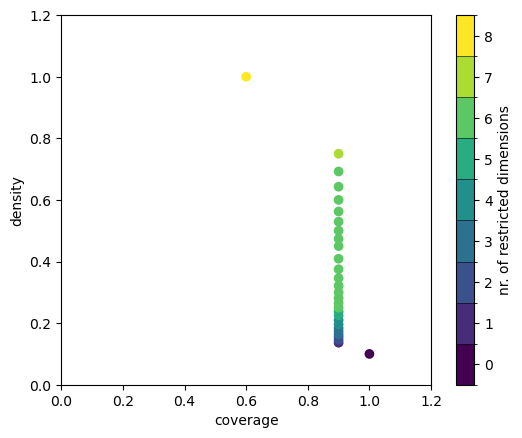

In [23]:
# Show the peeling graph for this prim analysis
box1.show_tradeoff()
plt.show()

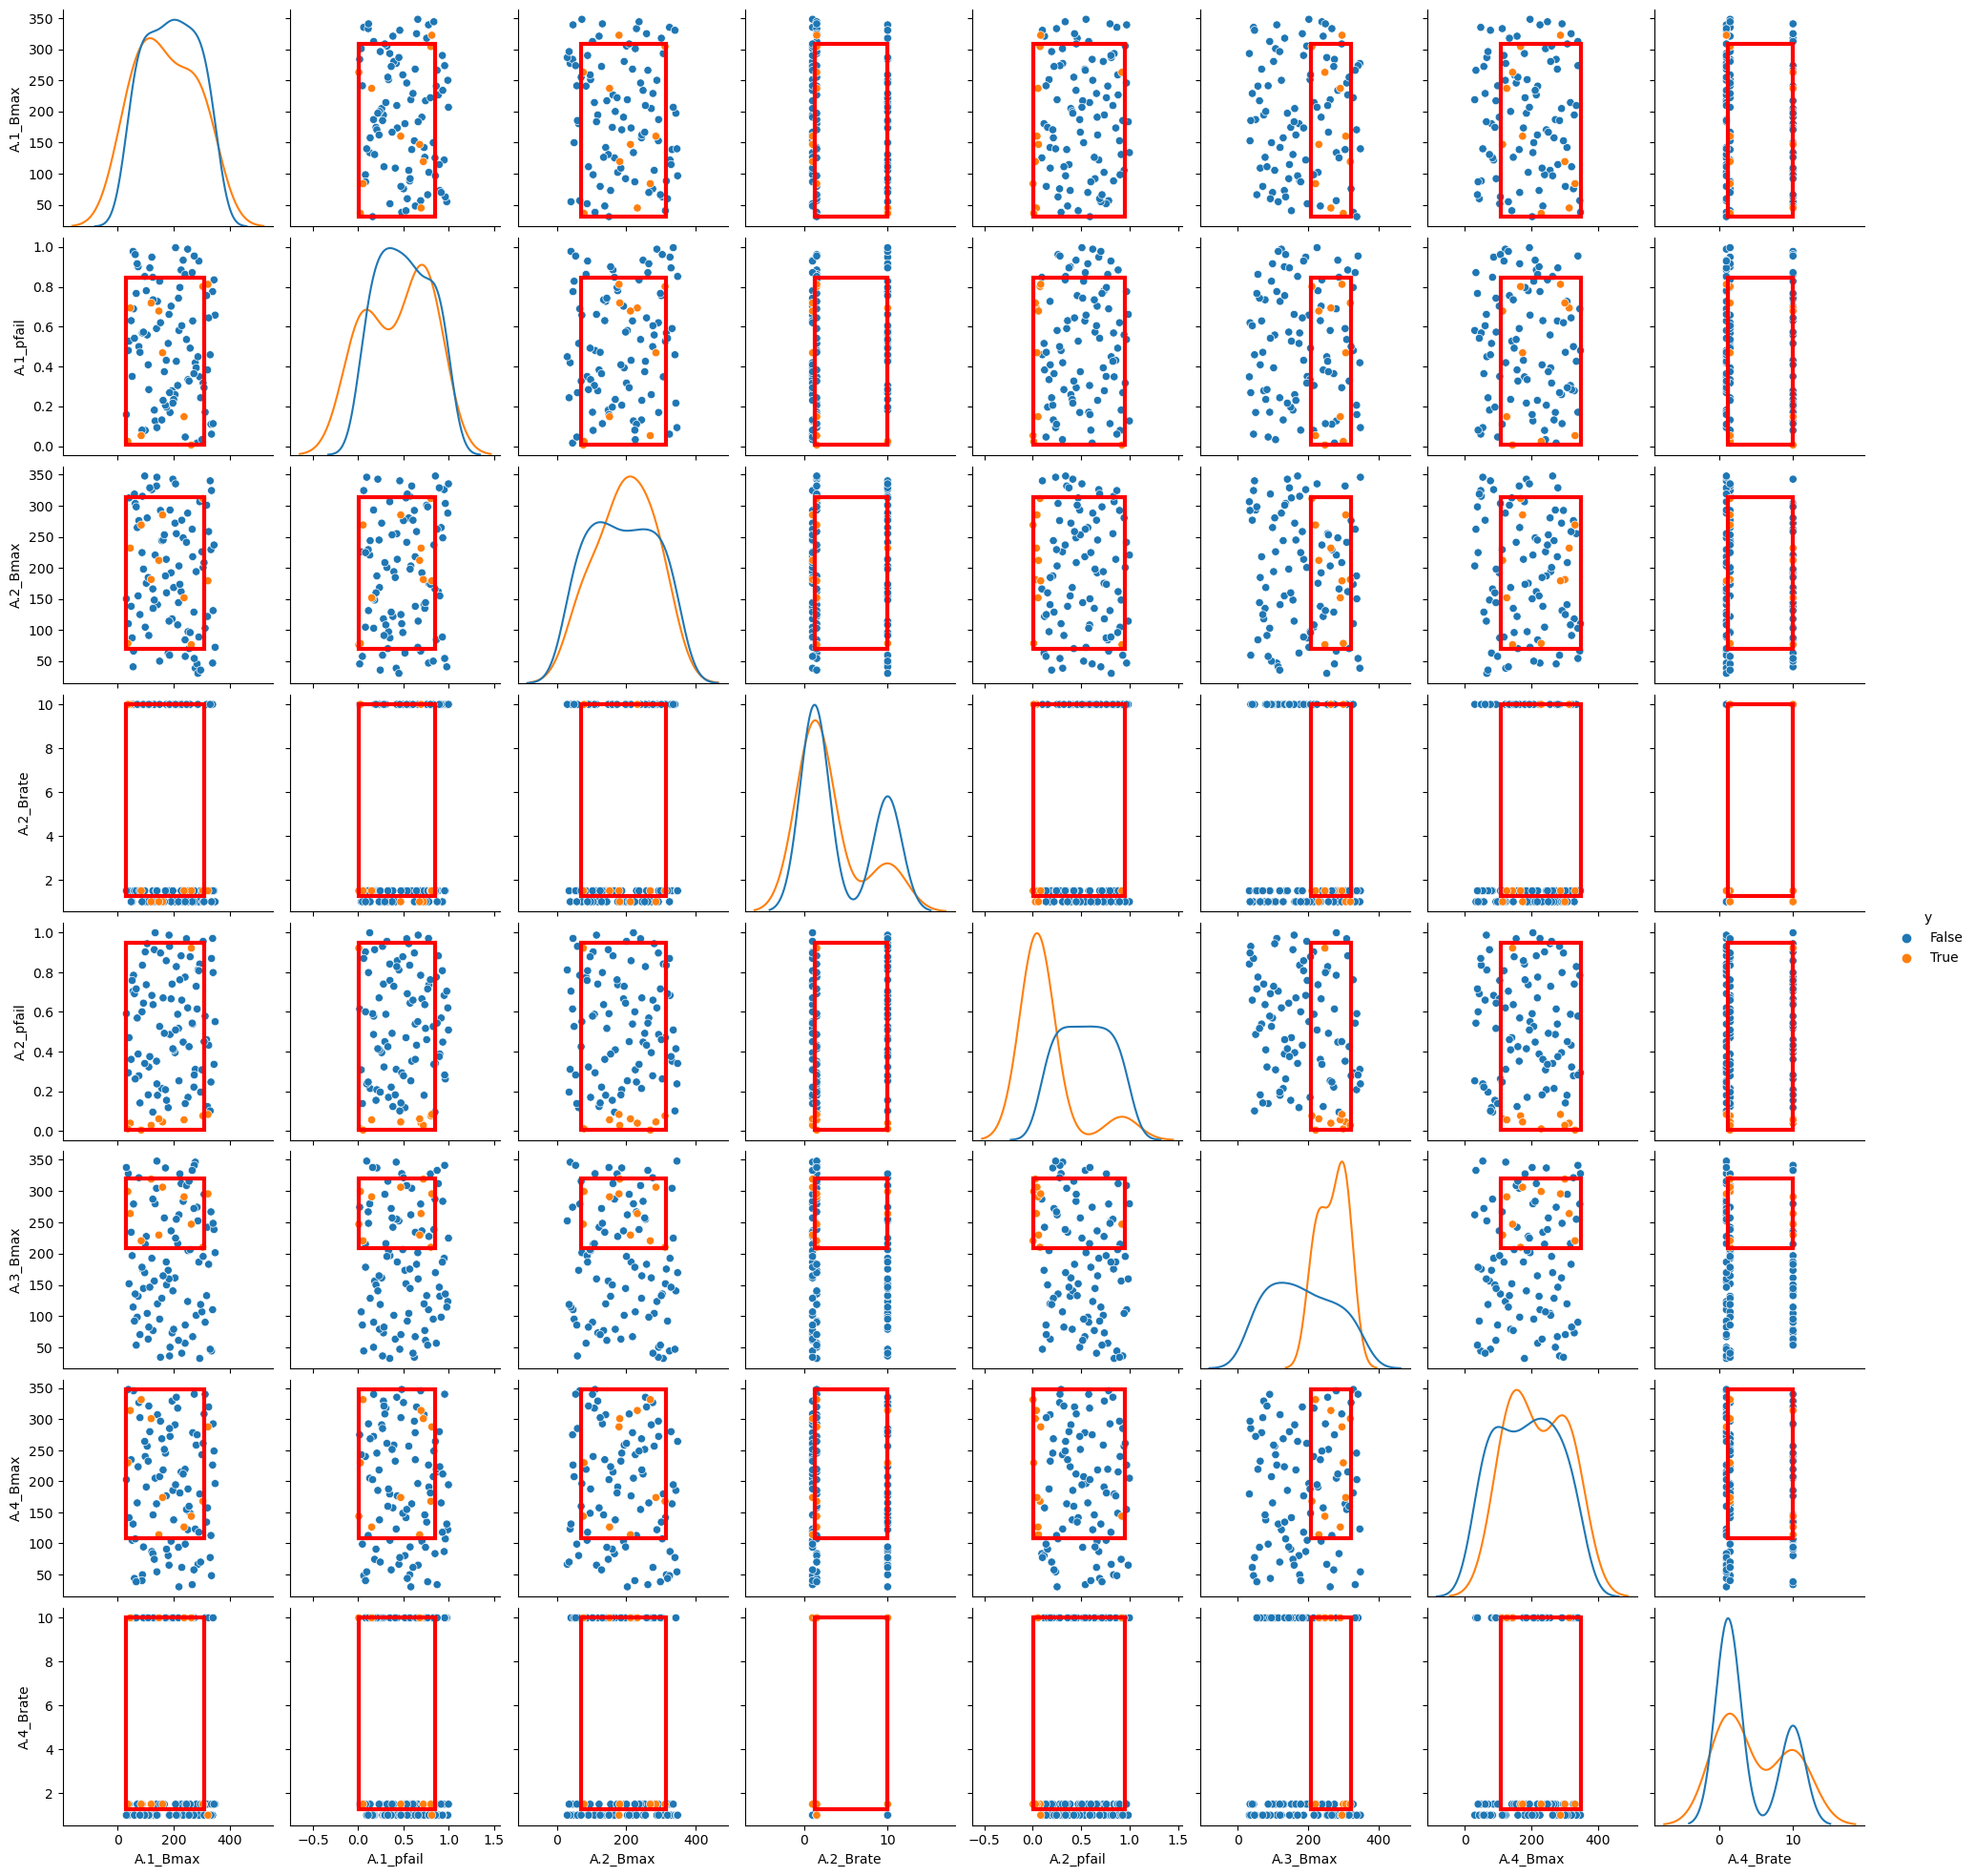

In [24]:
# Show scatter plots for this prim analysis
box1.show_pairs_scatter()
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category


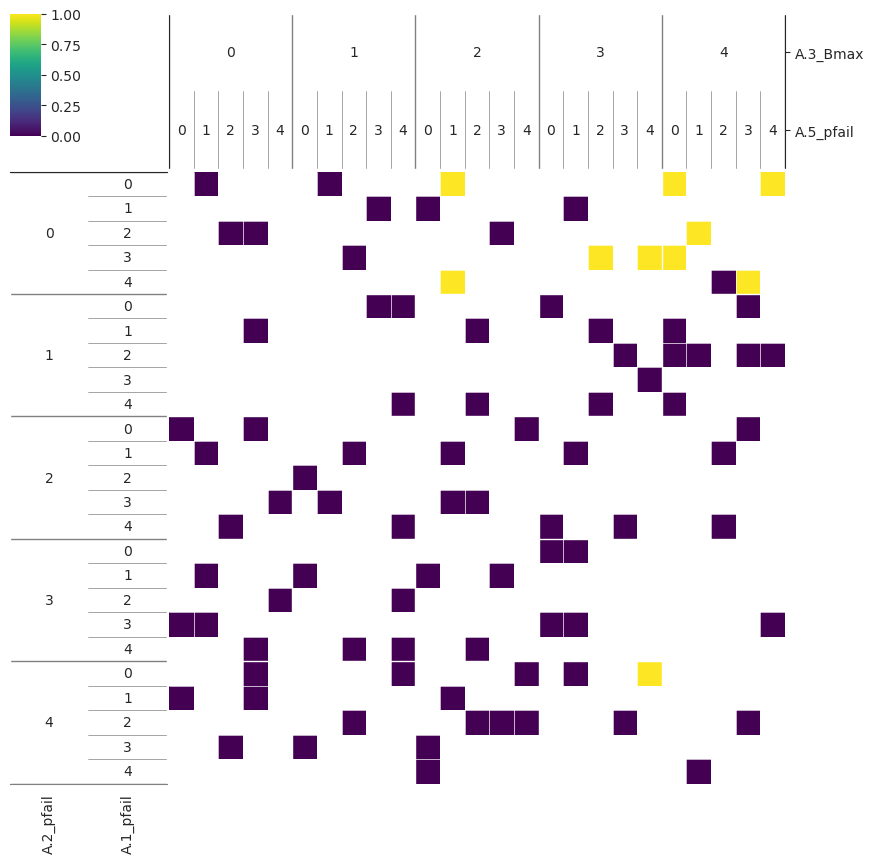

In [25]:
# Do dimensional stacking of results
# https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/dimensional_stacking.html#ema_workbench.analysis.dimensional_stacking.create_pivot_plot

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=5)
plt.show()

## Global Sensitivity Analysis 

In [26]:
# Define a reference scenario with each uncertainty containing the mean value of its range
scenarios = [Scenario('scenario 1', **{'discount rate 0':3,
                                        'discount rate 1':3,
                                        'discount rate 2':3,
                                        'A.1_Bmax':190,
                                        'A.1_Brate':1.5,
                                        'A.1_pfail':0.5,
                                        'A.2_Bmax':190,
                                        'A.2_Brate':1.5,
                                        'A.2_pfail':0.5,
                                        'A.3_Bmax':190,
                                        'A.3_Brate':1.5,
                                        'A.3_pfail':0.5,
                                        'A.4_Bmax':190,
                                        'A.4_Brate':1.5,
                                        'A.4_pfail':0.5,
                                        'A.5_Bmax':190,
                                        'A.5_Brate':1.5,
                                        'A.5_pfail':0.5,
                                        'A.0_ID flood wave shape':66})
                                    ]

ema_logging.log_to_stderr(ema_logging.INFO)

# Use problem formulation 3 (disaggregated dike rings)
dike_model, planning_steps = get_model_for_problem_formulation(6)


# Perform experiments using SOBOL sampling, in this case used for the levers.
with MultiprocessingEvaluator(dike_model) as evaluator:
    gsa_results = evaluator.perform_experiments(
        scenarios=scenarios, policies=256, lever_sampling=Samplers.SOBOL)


[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 16384 policies * 1 model(s) = 16384 experiments
RfR Total Costs not found in model output
Expected Evacuation Costs not found in model output
RfR Total Costs not found in model output
Expected Evacuation Costs not found in model output
RfR Total Costs not found in model output
Expected Evacuation Costs not found in model output
unsupported operand type(s) for +: 'int' and 'NoneType'
Traceback (most recent call last):
  File "/Users/philipmuller/opt/anaconda3/envs/mbdm/lib/python3.11/site-packages/ema_workbench/em_framework/experiment_runner.py", line 91, in run_experiment
    model.run_model(scenario, policy)
  File "/Users/philipmuller/opt/anaconda3/envs/mbdm/lib/python3.11/site-packages/ema_workbench/util/ema_logging.py", line 152, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/philipmuller/opt/anaconda3/envs/mbdm/lib/python3.11/site-packages/ema_workb

KeyboardInterrupt: 

In [ ]:
# Save results from the global sensitivity analysis
save_results(gsa_results, 'results/1 scenarios 256 policy PF3 SA lever.tar.gz')
# Load results from the global sensitivity analysis
load_file_name = 'results/1 scenarios 256 policy PF3 SA lever.tar.gz'
gsa_results = load_results(load_file_name)

In [ ]:
# Convert our problem to SALib format using EMA's builtin function
experiments, outcomes = gsa_results
problem = get_SALib_problem(dike_model.levers)

# Using the outputs and samples generated with SOBOL, do the actual global sensitivity analysis (based on variations)
Si = sobol.analyze(
    problem, outcomes['A.1_Expected Number of Deaths'], calc_second_order=True, print_to_console=False
)

In [ ]:
# Plot distributions of ST and ST1 of the values
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## Feature Scoring

In [27]:
plt.rcParams["figure.figsize"] = (8,7.5)

# load_file_name = '2000 scenarios 1 policy PF3.tar.gz'
load_file_name ='results/1 scenarios 256 policy PF3 SA lever.tar.gz'
results = load_results(load_file_name)

experiments, outcomes = results

# Drop levers for other time steps to make graph more compact and readable
experiments.drop(experiments.columns[:19], axis=1, inplace=True)
experiments.drop(columns=["0_RfR 1", "0_RfR 2", "1_RfR 1", "1_RfR 2", "2_RfR 1", "2_RfR 2", "3_RfR 1", "3_RfR 2",
                            "4_RfR 1", "4_RfR 2", "A.1_DikeIncrease 1", "A.1_DikeIncrease 2", "A.2_DikeIncrease 1", "A.2_DikeIncrease 2",
                            "A.3_DikeIncrease 1", "A.3_DikeIncrease 2", "A.4_DikeIncrease 1", "A.4_DikeIncrease 2", "A.5_DikeIncrease 1",
                            "A.5_DikeIncrease 2", "policy"], inplace=True)

x = experiments
y = outcomes

# Get feature scores for the SOBOL sampled inputs and their corresponding outputs
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="magma", annot=True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/1 scenarios 256 policy PF3 SA lever.tar.gz'